
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# ゼロからのリカレント ニューラル ネットワークの実装

:label: `sec_rnn-scratch`

これで、RNN を最初から実装する準備が整いました。特に、この RNN を文字レベル言語モデル ( :numref: `sec_rnn`参照) として機能するようにトレーニングし、HG Wells の*The Time Machine*の全テキストで構成されるコーパス上でトレーニングします。以下で概説したデータ処理手順に従います。 :numref: `sec_text-sequence` 。データセットをロードすることから始めます。


In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


## RNNモデル

まず、RNN モデル (:numref: `subsec_rnn_w_hidden_states` ) を実装するクラスを定義します。非表示ユニットの数`num_hiddens`調整可能なハイパーパラメーターであることに注意してください。


In [2]:
class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))


**[ 以下の`forward`メソッドは、現在の入力と前のタイム ステップでのモデルの状態を考慮して、任意のタイム ステップでの出力と隠れ状態を計算する方法を定義します。** ] RNN モデルは`inputs`の最も外側の次元をループし、隠れ状態を一度に 1 タイム ステップずつ更新することに注意してください。ここのモデルは $\tanh$ 活性化関数 (:numref: `subsec_tanh` ) を使用します。


In [3]:
@d2l.add_to_class(RNNScratch)  #@save
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
    else:
        state, = state
    outputs = []
    for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
        state = torch.tanh(torch.matmul(X, self.W_xh) +
                         torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state


次のように、入力シーケンスのミニバッチを RNN モデルにフィードできます。


In [4]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)


RNN モデルが正しい形状の結果を生成するかどうかを確認して、隠れ状態の次元が変更されていないことを確認しましょう。


In [5]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))


## RNNベースの言語モデル

次の`RNNLMScratch`クラスは、RNN ベースの言語モデルを定義します。ここで、 `__init__`メソッドの`rnn`引数を介して RNN を渡します。言語モデルをトレーニングする場合、入力と出力は同じ語彙から行われます。したがって、それらは同じ次元を持ち、語彙サイズと同じになります。モデルを評価するためにパープレキシティを使用することに注意してください。 :numref: `subsec_perplexity`で説明したように、これにより、異なる長さのシーケンスが比較できることが保証されます。


In [6]:
class RNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)


### [**ワンホットエンコーディング**]

各トークンは、対応する単語/文字/単語片の語彙内の位置を示す数値インデックスによって表されることを思い出してください。 (各タイム ステップで) インデックスをスカラー値として入力できる、単一の入力ノードを持つニューラル ネットワークを構築したくなるかもしれません。これは、価格や温度などの数値入力を扱う場合に機能します。この場合、十分に近い 2 つの値は同様に処理される必要があります。しかし、これではまったく意味がわかりません。私たちの語彙の中の $45^{\mathrm{th}}$ と $46^{\mathrm{th}}$ という単語はたまたま「彼ら」と「言った」であり、その意味はほとんど似ていません。

このようなカテゴリ データを扱う場合、最も一般的な戦略は、各項目を*ワンホット エンコーディング*で表すことです (:numref: `subsec_classification-problem`を思い出してください)。ワンホット エンコーディングは、その長さが語彙 $N$ のサイズによって与えられるベクトルです。ここで、$1$ に設定されるトークンに対応するエントリを除き、すべてのエントリが $0$ に設定されます。たとえば、語彙に 5 つの要素がある場合、インデックス 0 と 2 に対応するワンホット ベクトルは次のようになります。


In [7]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])


**( 各反復でサンプリングするミニバッチは、形状 (バッチ サイズ、タイム ステップ数) をとります。各入力をワンホット ベクトルとして表すと、各ミニバッチを 3 次元のテンソルとして考えることができます。 3 番目の軸に沿った値は語彙サイズ ( `len(vocab)` ) によって与えられます。** ) 形状 (タイム ステップ数、バッチ サイズ、語彙サイズ) の出力を取得するために、入力を転置することがよくあります。これにより、ミニバッチの隠れ状態を時間ステップごとに更新するために最も外側の次元をループすることがより便利になります (たとえば、上記の`forward`メソッドで)。


In [8]:
@d2l.add_to_class(RNNLMScratch)  #@save
def one_hot(self, X):
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)


### RNN 出力の変換

言語モデルは、完全に接続された出力層を使用して、各タイム ステップで RNN 出力をトークン予測に変換します。


In [9]:
@d2l.add_to_class(RNNLMScratch)  #@save
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1)

@d2l.add_to_class(RNNLMScratch)  #@save
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)


[**順方向計算で正しい形状の出力が生成されるかどうかを確認してみましょう。** 】


In [10]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))


## [**グラデーションクリッピング**]

ニューラル ネットワークは、単一のタイム ステップ内であっても多くの層が入力と出力を分離しているという意味で「深い」と考えることにすでに慣れていますが、シーケンスの長さによって深さという新しい概念が導入されます。入力から出力方向にネットワークを通過することに加えて、最終時間のモデルの出力に影響を与えるために、最初のタイム ステップの入力はタイム ステップに沿って $T$ 層のチェーンを通過する必要があります。ステップ。逆方向から見ると、各反復で時間の経過とともに勾配を逆伝播し、その結果、長さ $\mathcal{O}(T)$ の行列積のチェーンが得られます。 :numref: `sec_numerical_stability`で説明したように、これにより数値が不安定になり、重み行列のプロパティに応じて勾配が爆発または消滅する可能性があります。

勾配の消失と爆発の処理は、RNN を設計する際の基本的な問題であり、最新のニューラル ネットワーク アーキテクチャにおける最大の進歩の一部に影響を与えました。次の章では、勾配消失問題を軽減するために設計された特殊なアーキテクチャについて説明します。ただし、最新の RNN でも依然として爆発的な勾配に悩まされることがよくあります。洗練されていないが普遍的な解決策の 1 つは、単純に勾配をクリップして、結果として生じる「クリップされた」勾配がより小さい値になるようにすることです。

一般的に、勾配降下法によって何らかの目的を最適化する場合、対象となるパラメータ、たとえばベクトル $\mathbf{x}$ を繰り返し更新しますが、それを負の勾配 $\mathbf{g}$ (確率論的) の方向に押し進めます。勾配降下法では、ランダムにサンプリングされたミニバッチでこの勾配を計算します)。たとえば、学習率 $\eta &gt; 0$ の場合、各更新は $\mathbf{x} \gets \mathbf{x} - \eta \mathbf{g}$ の形式になります。さらに、目的関数 $f$ が十分に滑らかであると仮定しましょう。形式的には、目的は定数 $L$ を持つ*リプシッツ連続*であると言います。これは、任意の $\mathbf{x}$ と $\mathbf{y}$ について、次のことを意味します。

 $$|f(\mathbf{x}) - f(\mathbf{y})| \leq L |\mathbf{x} - \mathbf{y}|.$$

ご覧のとおり、 $\eta \mathbf{g}$ を減算してパラメーター ベクトルを更新すると、目的の値の変化は次のように学習率、勾配のノルム、および $L$ に依存します。

 $$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta|\mathbf{g}|.$$

言い換えれば、目的は $L \eta |\mathbf{g}|$ を超えて変更することはできません。この上限の値が小さいことは、良いこととみなされる場合もあれば、悪いこととみなされる場合もあります。マイナス面としては、目標の価値を下げる速度が制限されていることです。明るい面としては、これにより、1 つのグラデーション ステップでどれだけ間違える可能性があるかが制限されます。

勾配が爆発すると言うとき、$|\mathbf{g}|$ が過度に大きくなることを意味します。この最悪のケースでは、単一の勾配ステップで非常に多くのダメージを与える可能性があり、何千回ものトレーニング反復の過程で得られたすべての進歩を元に戻す可能性があります。勾配が非常に大きくなる可能性がある場合、ニューラル ネットワークのトレーニングが発散し、目標の価値を低減できないことがよくあります。また、トレーニングは最終的には収束しますが、損失が大幅に急増するため不安定になる場合もあります。

 $L \eta |\mathbf{g}|$ のサイズを制限する 1 つの方法は、学習率 $\eta$ を小さな値に縮小することです。ここでの利点の 1 つは、更新に偏りがないことです。しかし、大きな勾配がほとんど発生し*ない*場合はどうなるでしょうか?この思い切った動きは、まれに起こる爆発的な勾配イベントに対処するためだけに、あらゆる段階で私たちの進歩を遅らせます。一般的な代替案は、次のように、勾配 $\mathbf{g}$ を特定の半径 $\theta$ のボールに投影する*勾配クリッピング*ヒューリスティックを採用することです。

 **( $$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{|\mathbf{g}|}\right) \mathbf{g}.$$ )**

これにより、勾配ノルムが $\theta$ を決して超えず、更新された勾配が $\mathbf{g}$ の元の方向と完全に一致することが保証されます。また、任意のミニバッチ (およびその中の任意のサンプル) がパラメーター ベクトルに及ぼす影響を制限するという望ましい副作用もあります。これにより、モデルにある程度の堅牢性が与えられます。はっきり言って、これはハッキングです。勾配クリッピングは、常に真の勾配に従っていないことを意味し、起こり得る副作用について分析的に推論するのは困難です。ただし、これは非常に便利なハックであり、ほとんどの深層学習フレームワークの RNN 実装で広く採用されています。

以下では、 `d2l.Trainer`クラスの`fit_epoch`メソッドによって呼び出される、グラデーションをクリップするメソッドを定義します ( :numref: `sec_linear_scratch`を参照)。勾配ノルムを計算するとき、すべてのモデル パラメーターを連結し、それらを単一の巨大なパラメーター ベクトルとして扱うことに注意してください。


In [11]:
@d2l.add_to_class(d2l.Trainer)  #@save
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm


## トレーニング

*Time Machine*データセット ( `data` ) を使用して、最初から実装された RNN ( `rnn` ) に基づいて文字レベル言語モデル ( `model` ) をトレーニングします。最初に勾配を計算し、次にそれらをクリップし、最後にクリップされた勾配を使用してモデル パラメーターを更新することに注意してください。


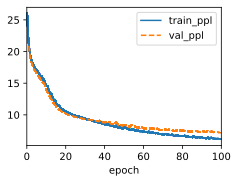

In [12]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)


## デコード

言語モデルを学習すると、それを使用して次のトークンを予測するだけでなく、後続の各トークンの予測を継続し、以前に予測されたトークンを入力内の次のトークンであるかのように扱うことができます。文書の先頭から開始するかのようにテキストを生成したい場合があります。ただし、多くの場合、ユーザーが指定した接頭辞に基づいて言語モデルを条件付けると便利です。たとえば、検索エンジン用のオートコンプリート機能を開発したり、ユーザーのメール作成を支援したりする場合、ユーザーがこれまでに書いた内容 (プレフィックス) を入力して、可能性の高い継続を生成したいと考えるでしょう。

 [**次の`predict`メソッドは、ユーザー提供の`prefix`を取り込んだ後、一度に 1 文字ずつ継続を生成します。** ]、 `prefix`内の文字をループするとき、非表示状態を次のタイム ステップに渡し続けますが、出力は生成されません。これを*ウォームアップ*期間と呼びます。プレフィックスを取り込んだ後、後続の文字の出力を開始する準備が整いました。各文字は後続のタイム ステップで入力としてモデルにフィードバックされます。


In [13]:
@d2l.add_to_class(RNNLMScratch)  #@save
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])


以下では、プレフィックスを指定し、追加の 20 文字を生成します。


In [14]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has of the the the the '


上記の RNN モデルを最初から実装することは有益ですが、便利ではありません。次のセクションでは、深層学習フレームワークを活用して、標準アーキテクチャを使用して RNN を構築し、高度に最適化されたライブラリ関数に依存してパフォーマンスの向上を得る方法を説明します。

## まとめ

RNN ベースの言語モデルをトレーニングして、ユーザーが指定したテキスト接頭辞に続くテキストを生成できます。単純な RNN 言語モデルは、入力エンコード、RNN モデリング、出力生成で構成されます。トレーニング中に、勾配クリッピングは勾配の爆発の問題を軽減できますが、勾配の消失の問題には対処しません。実験では、単純な RNN 言語モデルを実装し、文字レベルでトークン化されたテキストのシーケンスに対する勾配クリッピングを使用してそれをトレーニングしました。プレフィックスに基づいて条件付けすることにより、言語モデルを使用して可能性の高い継続を生成できます。これは、オートコンプリート機能など、多くのアプリケーションで役立つことが証明されています。

## 演習
1. 実装された言語モデルは、 *Time Machine*の最初のトークンまでの過去のすべてのトークンに基づいて次のトークンを予測しますか?
1. 予測に使用される履歴の長さを制御するハイパーパラメーターはどれですか?
1. ワンホット エンコーディングが、オブジェクトごとに異なる埋め込みを選択することと同等であることを示します。
1. ハイパーパラメータ (エポック数、隠れユニット数、ミニバッチ内のタイム ステップ数、学習率など) を調整して、複雑さを改善します。このシンプルなアーキテクチャを維持しながら、どこまで低くできるでしょうか?
1. ワンホット エンコーディングを学習可能な埋め込みに置き換えます。これはパフォーマンスの向上につながりますか?
1.  *The Time Machine*でトレーニングされたこの言語モデルが、HG Wells の他の書籍 (たとえば、 [The War of the Worlds)](http://www.gutenberg.org/ebooks/36)でどの程度うまく機能するかを判断するための実験を実施します。
1. 他の著者が書いた本についてこのモデルの複雑さを評価するために別の実験を実施します。
1. 最も可能性の高い次の文字を選択するのではなく、サンプリングを使用するなど、予測方法を変更します。<ul><li>何が起こるのですか？
1.  $q(x_t \mid x_{t-1}, \ldots, x_1) \propto P(x_t \mid x_{t-1}, \ldots, x_1) からサンプリングするなどして、より可能性の高い出力に向けてモデルにバイアスをかけます。 $\alpha &gt; 1$ の場合は ^\alpha$。
</ul></li>1. グラデーションをクリップせずに、このセクションのコードを実行します。何が起こるのですか？
1. このセクションで使用する活性化関数を ReLU に置き換えて、このセクションの実験を繰り返します。まだグラデーションクリッピングが必要ですか?なぜ？



[ディスカッション](https://discuss.d2l.ai/t/486)
